In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [89]:
df = pd.read_csv('https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv')
df['median_income'] *= 10000 
df.info() 
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           17000 non-null  float64
 1   latitude            17000 non-null  float64
 2   housing_median_age  17000 non-null  float64
 3   total_rooms         17000 non-null  float64
 4   total_bedrooms      17000 non-null  float64
 5   population          17000 non-null  float64
 6   households          17000 non-null  float64
 7   median_income       17000 non-null  float64
 8   median_house_value  17000 non-null  float64
dtypes: float64(9)
memory usage: 1.2 MB


,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,-119.562108,35.625225,28.589353,2643.664412,539.410824,1429.573941,501.221941,38835.781000,207300.912353
std,2.005166,2.137340,12.586937,2179.947071,421.499452,1147.852959,384.520841,19081.565184,115983.764387
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,4999.000000,14999.000000
25%,-121.790000,33.930000,18.000000,1462.000000,297.000000,790.000000,282.000000,25663.750000,119400.000000
50%,-118.490000,34.250000,29.000000,2127.000000,434.000000,1167.000000,409.000000,35446.000000,180400.000000
75%,-118.000000,37.720000,37.000000,3151.250000,648.250000,1721.000000,605.250000,47670.000000,265000.000000
max,-114.310000,41.950000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,150001.000000,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

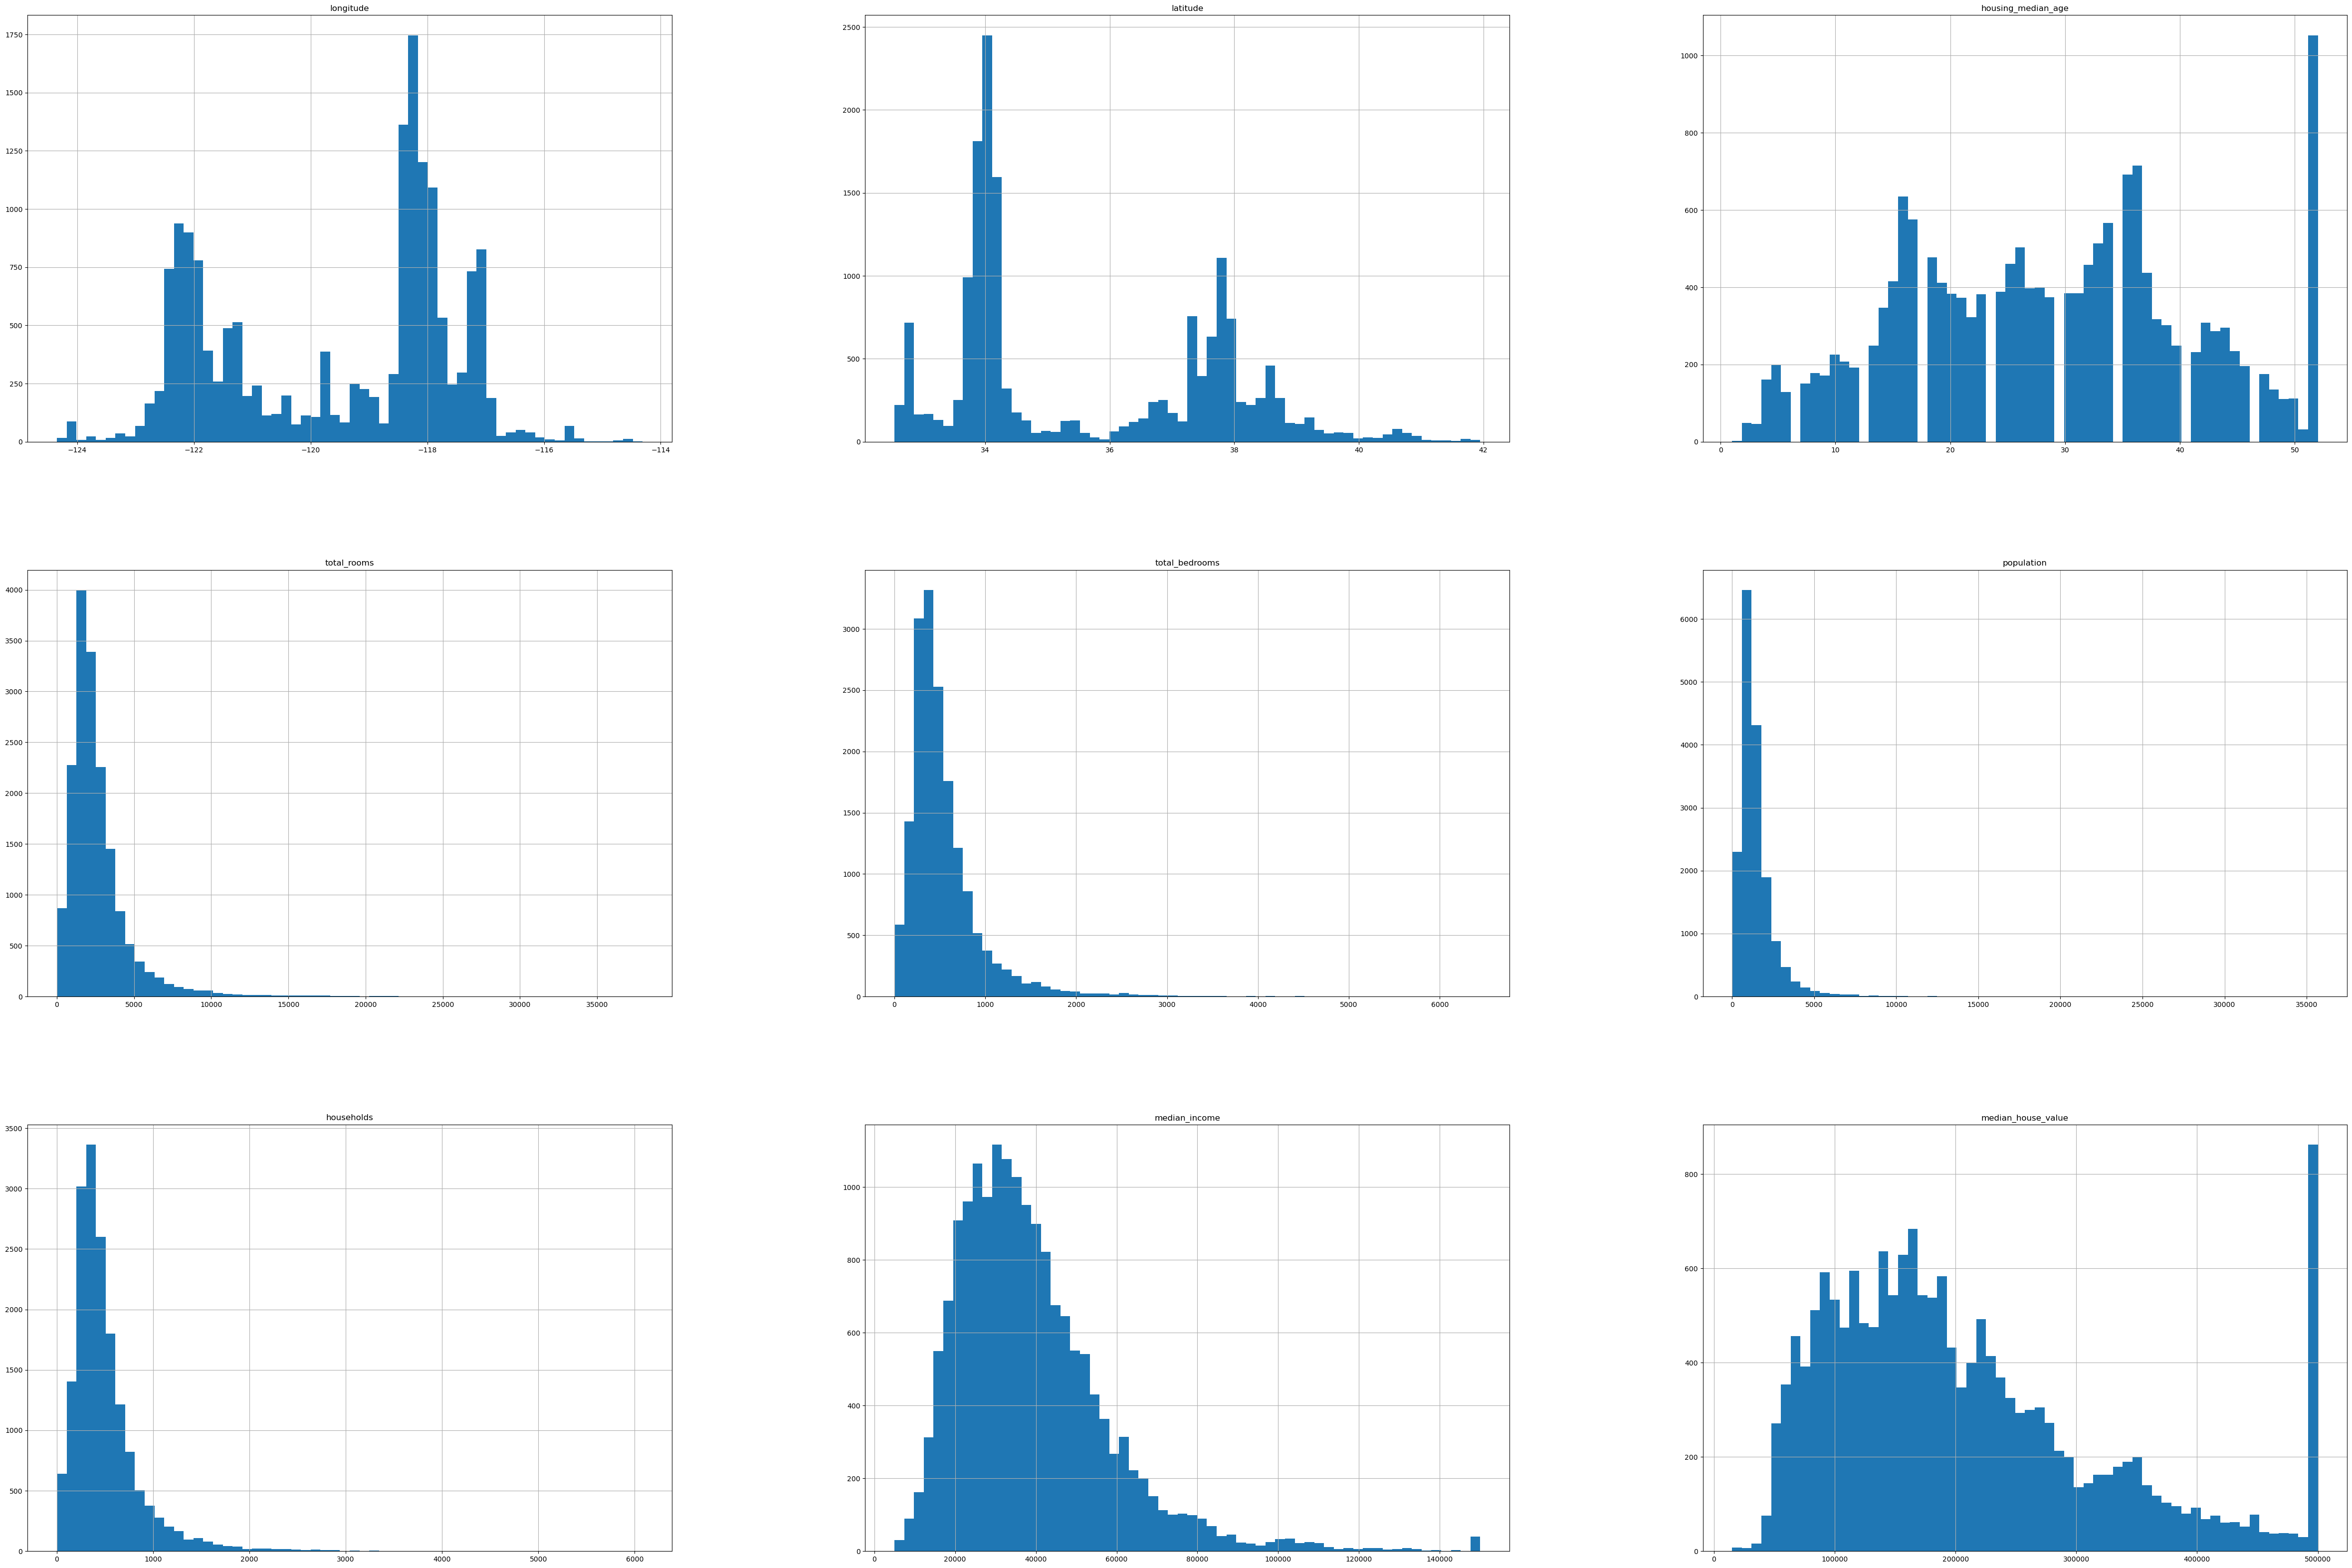

In [64]:
#Визуализировали распределение всех признаков
df.hist(bins=60, figsize=(60, 40))

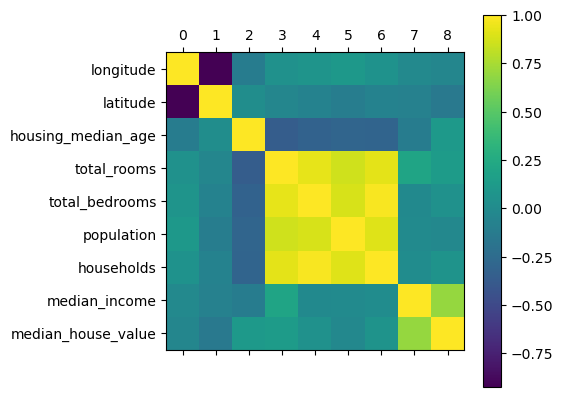

In [65]:
# Тепловая карта корреляций
plt.matshow(df.corr())
plt.yticks(range(len(df.columns)), df.columns)
plt.colorbar()

0.6918706037806709


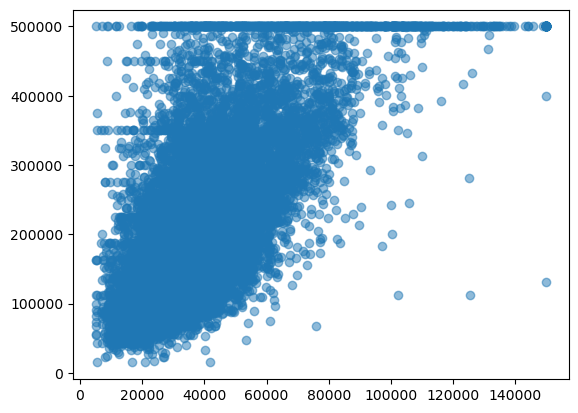

In [66]:
plt.scatter(df['median_income'], df['median_house_value'], alpha=0.5)
print(df.corr()['median_income']['median_house_value'])

видно, что доход и стоимость дома соотносятся слабо

0.9190182976946507


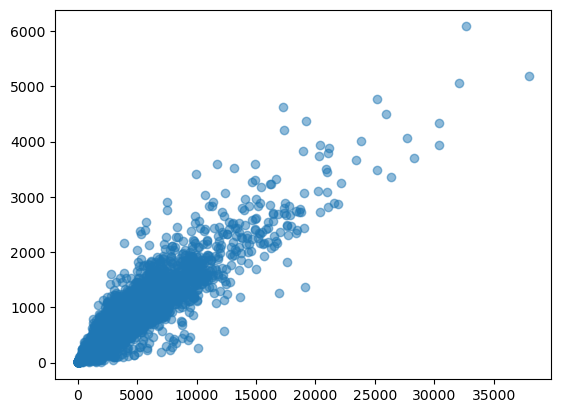

In [67]:
plt.scatter(df['total_rooms'], df['households'], alpha=0.5)
print(df.corr()['total_rooms']['households'])

0.9284029878168417


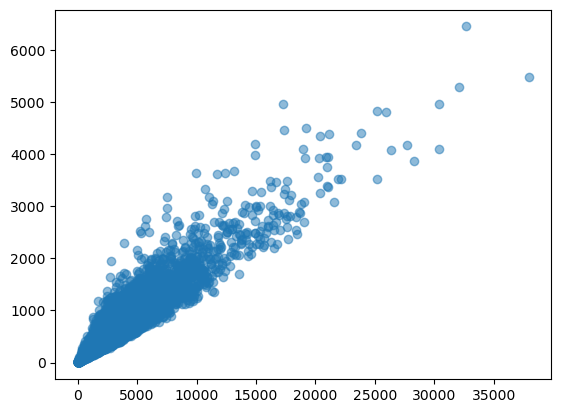

In [68]:
plt.scatter(df['total_rooms'], df['total_bedrooms'], alpha=0.5)
print(df.corr()['total_rooms']['total_bedrooms'])

0.8601703408101828


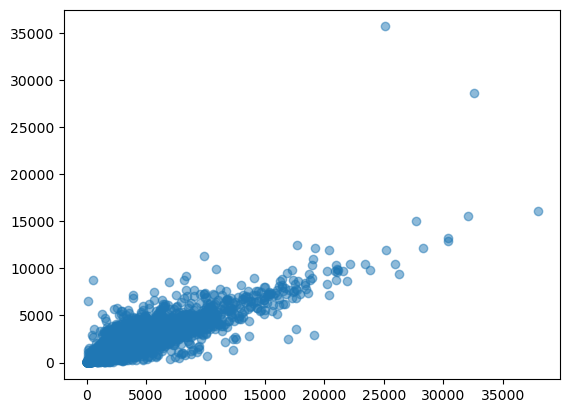

In [69]:
plt.scatter(df['total_rooms'], df['population'], alpha=0.5)
print(df.corr()['total_rooms']['population'])

In [70]:
# Создание класса линейной регрессии
class LSM:
    def __init__(self, col_names: list[str]):
        self.col_names = col_names

    @staticmethod
    def _prepend_ones(x):
        return np.concatenate((np.ones((len(x), 1)), x), axis=1)

    @staticmethod
    def sum_of_squares(true_y, pred_y):
        return np.sum(np.square(true_y - pred_y))

    @staticmethod
    def determination_coefficient(true_y, pred_y):
        mean_y = np.mean(true_y)
        rss = np.sum(np.square(true_y - pred_y))
        tss = np.sum(np.square(true_y - mean_y))

        return 1 - rss / tss

    def train(self, x: pd.DataFrame, y: pd.Series):
        x = LSM._prepend_ones(np.array(x[self.col_names]))
        y = np.array(y)
        self.b = np.linalg.inv((x.T @ x)) @ x.T @ y

    def pred(self, x: pd.DataFrame) -> list[float]:
        return np.array(LSM._prepend_ones(x[self.col_names])) @ self.b.T

# Этап 4: Разделение данных

тестовые и тренировочные данные для денежной зависимости

In [71]:

train_percent = 0.7
random_state = 6546546

train = df.sample(frac=train_percent, random_state=random_state)
test = df.drop(train.index)
train_x = train.drop('median_house_value', axis=1)
train_y = train['median_house_value']
test_x = test.drop('median_house_value', axis=1)
test_y = test['median_house_value']

# Этап 5: модели

модель по всем признакам

In [72]:
lsm = LSM(train_x.columns)
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.6557894510207746
Сумма квадратов: 24046204638881.105


модель только по median_income (доход)


In [73]:
lsm = LSM(['median_income'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.4969783417731215
Сумма квадратов: 35140589872633.055


тестовые и тренировочные данные для зависимости количества комнат

In [74]:
train_percent = 0.7
random_state = 6546546

train = df.sample(frac=train_percent, random_state=random_state)
test = df.drop(train.index)
train_x = train.drop('total_rooms', axis=1)
train_y = train['total_rooms']
test_x = test.drop('total_rooms', axis=1)
test_y = test['total_rooms']

модель по всем признакам

In [75]:
lsm = LSM(train_x.columns)
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.928606328252443
Сумма квадратов: 1686390448.815234


модель по total_bedrooms (спальням)

In [76]:
lsm = LSM(['total_bedrooms'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.869774699773403
Сумма квадратов: 3076052780.5987854


модель по households (количество домохозяйств)

In [77]:
lsm = LSM(['households'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.8649933622321864
Сумма квадратов: 3188992790.0520086


модель по population (количество людей)

In [78]:
lsm = LSM(['population'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.7701169720281144
Сумма квадратов: 5430068705.351034


модель по всем трём параметрам population, households, total_bedrooms

In [79]:
lsm = LSM(['population', 'households', 'total_bedrooms'])
lsm.train(train_x, train_y)
pred_y = lsm.pred(test_x)
print('Коэффициент детерминации:', LSM.determination_coefficient(test_y, pred_y))
print('Сумма квадратов:', LSM.sum_of_squares(test_y, pred_y))

Коэффициент детерминации: 0.8786157400820607
Сумма квадратов: 2867218502.0253353


In [90]:
# Итоговые выводы и анализ
# todo необходимо пофилософствовать на тему правильности этих выводов
print("Итоговые выводы:")
print(
    "1. Модель с использованием всех признаков имеет наивысший коэффициент детерминации (R^2), что показывает, что она лучше объясняет вариацию целевой переменной.")
print(
    "2. Среди индивидуальных признаков 'median_income' продемонстрировал наибольшую предсказательную способность, имея самый высокий R^2 среди моделей с одним признаком. Это означает, что доход жителей значительно влияет на стоимость жилья.")
print(
    "3. Признаки 'population', 'households' и 'total_bedrooms', взятые вместе, дали R^2 ниже, чем использование всех признаков, но выше, чем отдельные признаки. Это указывает на их взаимосвязь с целевой переменной.")
print(
    "4. Сравнение моделей показало, что для достижения хорошей точности стоит комбинировать признаки. Например, использование только одного признака может быть менее эффективным.")
print(
    "5. Добавление новых признаков значительно улучшает точность модели, но может увеличивать сложность и затраты на обучение.")

Итоговые выводы:
1. Модель с использованием всех признаков имеет наивысший коэффициент детерминации (R^2), что показывает, что она лучше объясняет вариацию целевой переменной.
2. Среди индивидуальных признаков 'median_income' продемонстрировал наибольшую предсказательную способность, имея самый высокий R^2 среди моделей с одним признаком. Это означает, что доход жителей значительно влияет на стоимость жилья.
3. Признаки 'population', 'households' и 'total_bedrooms', взятые вместе, дали R^2 ниже, чем использование всех признаков, но выше, чем отдельные признаки. Это указывает на их взаимосвязь с целевой переменной.
4. Сравнение моделей показало, что для достижения хорошей точности стоит комбинировать признаки. Например, использование только одного признака может быть менее эффективным.
5. Добавление новых признаков значительно улучшает точность модели, но может увеличивать сложность и затраты на обучение.
